In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import random
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=42):
    # Set seed for Python's built-in random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

# Define the custom dataset with lazy loading
class LazyLoadedScanNetDataset(Dataset):
    def __init__(self, scene_ids_file, data_dir, embedding_dir):
        self.scene_ids = self._load_scene_ids(scene_ids_file)
        self.data_dir = data_dir
        self.embedding_dir = embedding_dir

    def _load_scene_ids(self, scene_ids_file):
        with open(scene_ids_file, 'r') as f:
            scene_ids = f.read().splitlines()
        return scene_ids

    def _load_scene_data(self, scene_id):
        # Load the .pth file with coordinates, colors, and labels
        scene_data = torch.load(os.path.join(self.data_dir, f'{scene_id}_vh_clean_2.pth'))
        labels = scene_data[2]  # Assuming labels are provided per point

        # Load the fusion embeddings
        fusion_data = torch.load(os.path.join(self.embedding_dir, f'{scene_id}.pt'))
        embeddings = fusion_data['feat']
        mask = fusion_data['mask_full']

        # Filter embeddings and labels using the mask
        filtered_labels = labels[mask]

        # Convert to tensors if they are not already
        if not isinstance(embeddings, torch.Tensor):
            embeddings = torch.tensor(embeddings, dtype=torch.float32)
        if not isinstance(filtered_labels, torch.Tensor):
            filtered_labels = torch.tensor(filtered_labels, dtype=torch.long)

        # Replace label 255 with 20
        filtered_labels[filtered_labels == 255] = 20

        return embeddings, filtered_labels

    def __len__(self):
        return len(self.scene_ids)

    def __getitem__(self, idx):
        scene_id = self.scene_ids[idx]
        embeddings, labels = self._load_scene_data(scene_id)
        return embeddings, labels, scene_id

# Custom collate function to handle variable-sized point clouds
def custom_collate(batch):
    embeddings_list = []
    labels_list = []
    scene_ids = []

    for embeddings, labels, scene_id in batch:
        embeddings_list.append(embeddings)
        labels_list.append(labels)
        scene_ids.append(scene_id)

    return embeddings_list, labels_list, scene_ids


In [2]:
# Define the segmentation model
class SimpleSegmentationModel(nn.Module):
    def __init__(self, input_dim=1024, num_classes=21):
        super(SimpleSegmentationModel, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc(x.float())
        pred = self.softmax(x)
        return torch.log(pred)  # Return log-probabilities for NLLLoss

In [4]:
# Training function with gradient accumulation to avoid memory issues
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, accumulation_steps=4):
    best_val_loss = np.inf
    patience_counter = 0
    train_losses = []
    val_losses = []

    # Setup the plot
    plt.figure(figsize=(10, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')

    for epoch in range(10,20):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for batch_idx, (embeddings_list, labels_list, _) in enumerate(train_loader):
            for embeddings, labels in zip(embeddings_list, labels_list):
                embeddings = embeddings.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)

                # Forward pass
                outputs = model(embeddings)
                loss = criterion(outputs, labels)

                # Backward pass with gradient accumulation
                loss = loss / accumulation_steps
                loss.backward()

                if (batch_idx + 1) % accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                running_loss += loss.item()

        # Calculate training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for embeddings_list, labels_list, _ in val_loader:
                for embeddings, labels in zip(embeddings_list, labels_list):
                    embeddings = embeddings.to(device, dtype=torch.float32)
                    labels = labels.to(device, dtype=torch.long)

                    # Forward pass
                    outputs = model(embeddings)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

        # Calculate validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Update the plot
        plt.clf()
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.pause(0.001)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_mode_clip{epoch}.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    plt.ioff()
    plt.show()


In [5]:
# Hyperparameters and settings
batch_size = 1  # Use batch_size=1 for variable-sized point clouds
learning_rate = 0.0001
num_epochs = 10
accumulation_steps = 4  # Accumulate gradients over 4 mini-batches

# Create the datasets and data loaders
train_scene_ids_file = '/projectnb/compvision/charoori/openscene/data/scannet_3d/scannetv2_train_filtered1.txt'
train_data_dir = '/projectnb/compvision/charoori/openscene/data/scannet_3d/train'
train_embedding_dir = '/projectnb/compvision/jteja/Lexicon3D/lexicon3d/clip/clip_features'
train_dataset = LazyLoadedScanNetDataset(train_scene_ids_file, train_data_dir, train_embedding_dir)

val_scene_ids_file = '/projectnb/compvision/charoori/openscene/data/scannet_3d/scannetv2_val_filtered1.txt'
val_data_dir = '/projectnb/compvision/charoori/openscene/data/scannet_3d/val'
val_embedding_dir = '/projectnb/compvision/jteja/Lexicon3D/lexicon3d/clip/clip_features'
val_dataset = LazyLoadedScanNetDataset(val_scene_ids_file, val_data_dir, val_embedding_dir)

Epoch [1/10], Training Loss: 0.5846, Validation Loss: 2.1361


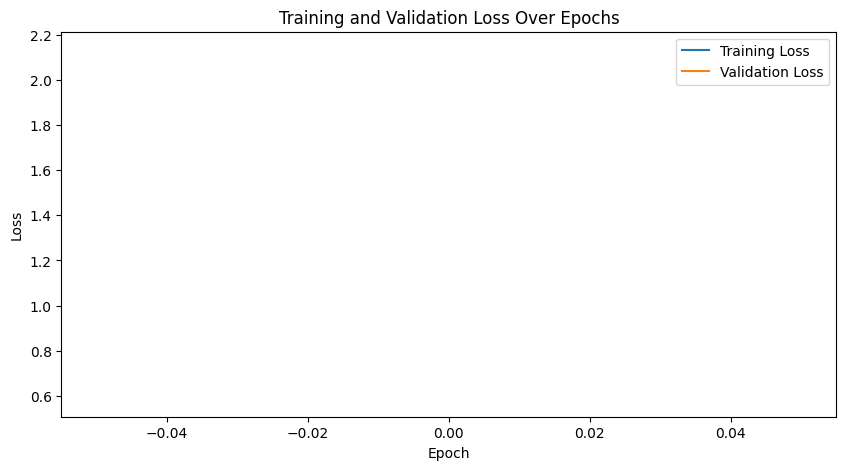

Epoch [2/10], Training Loss: 0.5307, Validation Loss: 2.0946


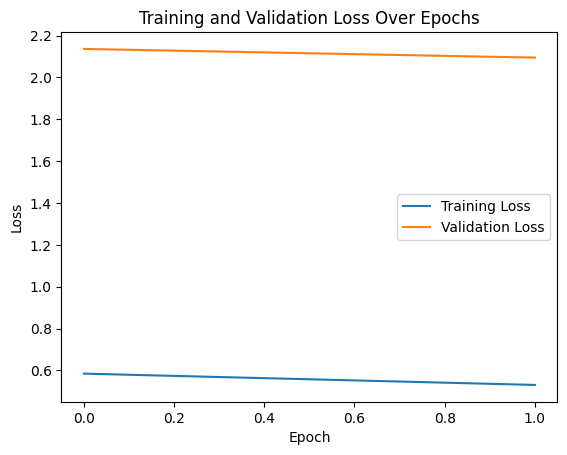

Epoch [3/10], Training Loss: 0.5225, Validation Loss: 2.0721


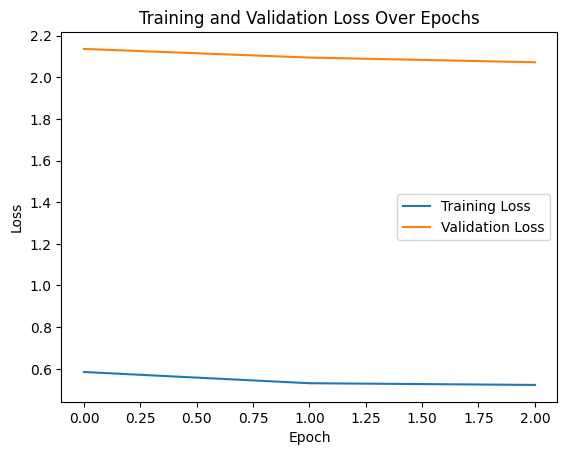

Epoch [4/10], Training Loss: 0.5182, Validation Loss: 2.0750


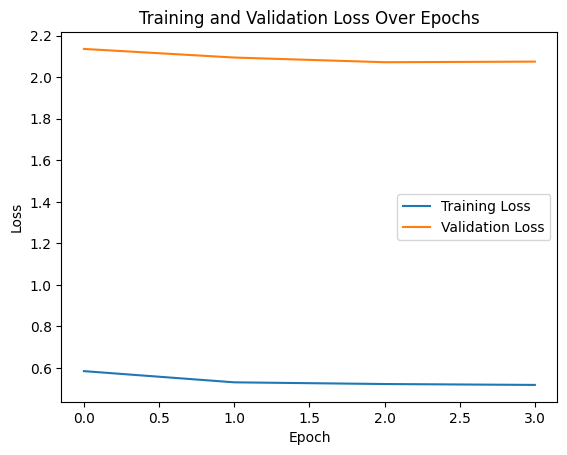

Epoch [5/10], Training Loss: 0.5149, Validation Loss: 2.0591


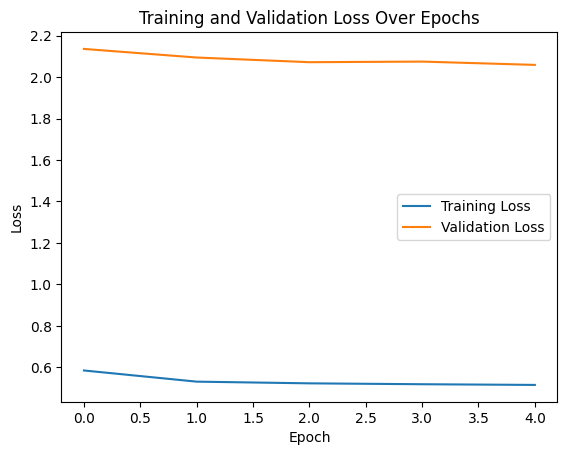

Epoch [6/10], Training Loss: 0.5124, Validation Loss: 2.0543


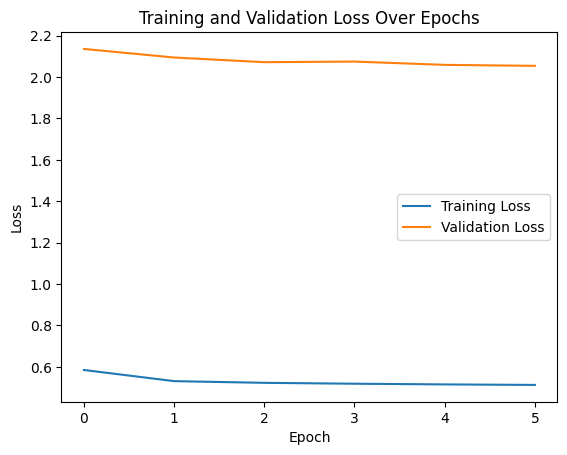

Epoch [7/10], Training Loss: 0.5111, Validation Loss: 2.0388


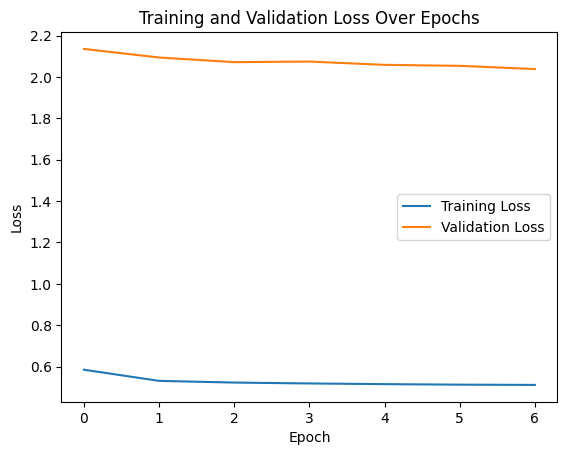

Epoch [8/10], Training Loss: 0.5096, Validation Loss: 2.0374


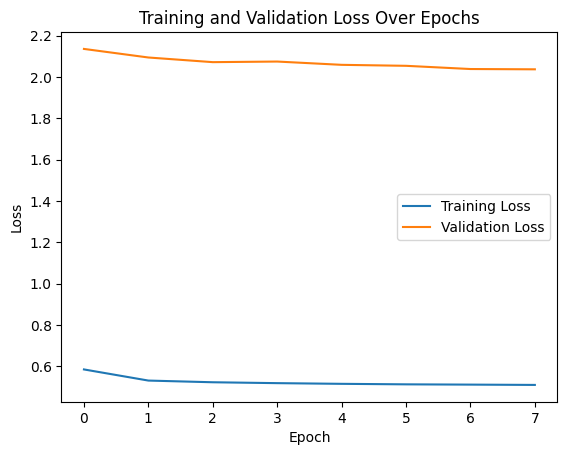

Epoch [9/10], Training Loss: 0.5077, Validation Loss: 2.0493


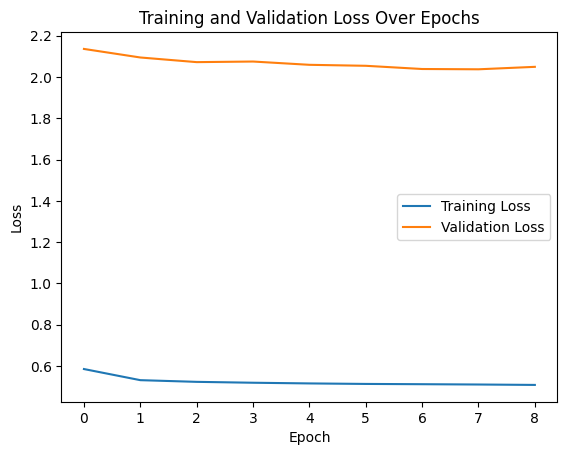

Epoch [10/10], Training Loss: 0.5068, Validation Loss: 2.0325


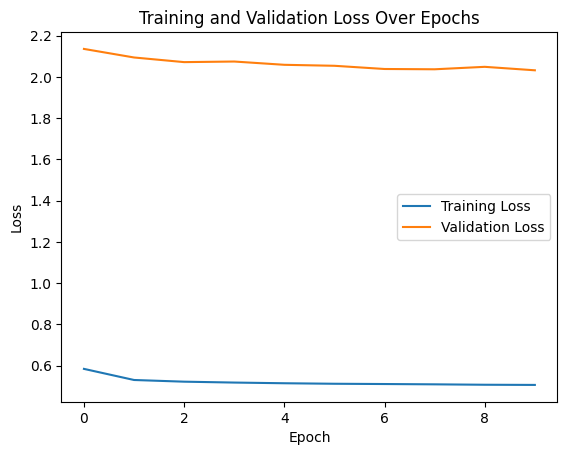

In [6]:
# Data loaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers = 32)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers = 32)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, criterion, and optimizer
model = SimpleSegmentationModel(input_dim=3072, num_classes=21).to(device)
criterion = nn.NLLLoss()  # Use NLLLoss since we are providing log-probabilities
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, accumulation_steps=accumulation_steps)